In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load the data from the CSV file
aranet4 = pd.read_csv('../datasets/aranet4.csv')
aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])
aranet4 = aranet4.set_index('Datetime')

aranetExp = pd.read_csv('../datasets/aranetExp.csv')
aranetExp['date'] = pd.to_datetime(aranetExp['date'])
aranetExp = aranetExp.rename(columns={'date': 'Datetime'})
aranetExp = aranetExp.drop(columns=['id','time'])
aranetExp = aranetExp.set_index('Datetime')

## Merge Data on Rounded Minute Records

In [2]:
# Create a copy of aranetExp
aranetExp_copy = aranetExp.copy()

# Round the 'Datetime' index to the nearest minute
aranetExp_copy.index = aranetExp_copy.index.round('min')
# Ensure each record has a unique datetime to the minute
unique_minutes = set()
for i in range(len(aranetExp_copy)):
    current_time = aranetExp_copy.index[i]
    original_time = current_time
    while current_time in unique_minutes:
        print(f"Changing {current_time} to ", end="")
        current_time += pd.Timedelta(minutes=1)
        print(f"{current_time}")
    if current_time != original_time:
        print(f"Original time {original_time} changed to {current_time}")
    unique_minutes.add(current_time)
    aranetExp_copy.index.values[i] = current_time

# aranetExp_copy.info()

# Create a copy of aranet4
aranet4_copy = aranet4.copy()
# Round the 'Datetime' index to the nearest minute
aranet4_copy.index = aranet4_copy.index.round('min')

# aranet4_copy.info()

# Merge aranet4_copy with aranetExp_copy using an exact match on the 'Datetime' index
merged = pd.merge(aranet4_copy, aranetExp_copy, left_on='Datetime', right_index=True, how='left')

# Display the info of the merged DataFrame
merged.info()

Changing 2024-03-13 13:08:00 to 2024-03-13 13:09:00
Original time 2024-03-13 13:08:00 changed to 2024-03-13 13:09:00
Changing 2024-03-18 12:25:00 to 2024-03-18 12:26:00
Original time 2024-03-18 12:25:00 changed to 2024-03-18 12:26:00
Changing 2024-03-18 12:26:00 to 2024-03-18 12:27:00
Original time 2024-03-18 12:26:00 changed to 2024-03-18 12:27:00
Changing 2024-03-19 09:18:00 to 2024-03-19 09:19:00
Original time 2024-03-19 09:18:00 changed to 2024-03-19 09:19:00
Changing 2024-03-25 10:18:00 to 2024-03-25 10:19:00
Original time 2024-03-25 10:18:00 changed to 2024-03-25 10:19:00
Changing 2024-04-02 12:34:00 to 2024-04-02 12:35:00
Original time 2024-04-02 12:34:00 changed to 2024-04-02 12:35:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118199 entries, 2024-01-12 16:08:00 to 2024-04-03 19:06:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Carbon dioxide(ppm)        118198 n

# Autocorrelations
Let's looks at autocorrelations and examine the residuals of our aranet4 sensor features.

In [4]:
# subset co2 data
co2 = aranet4[['Carbon dioxide(ppm)']].copy()
co2 = co2.rename(columns={'Carbon dioxide(ppm)': 'CO2'})
co2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118199 entries, 2024-01-12 16:08:15 to 2024-04-03 19:06:19
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   CO2     118198 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


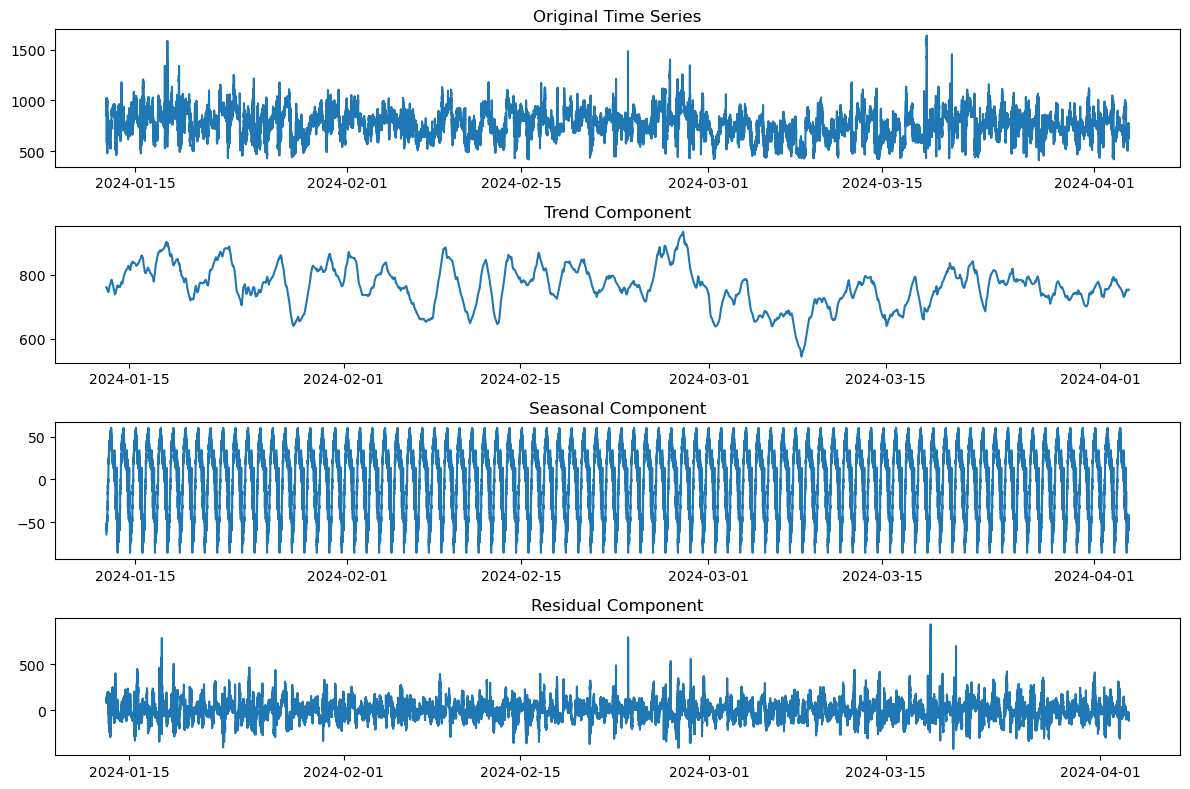

c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

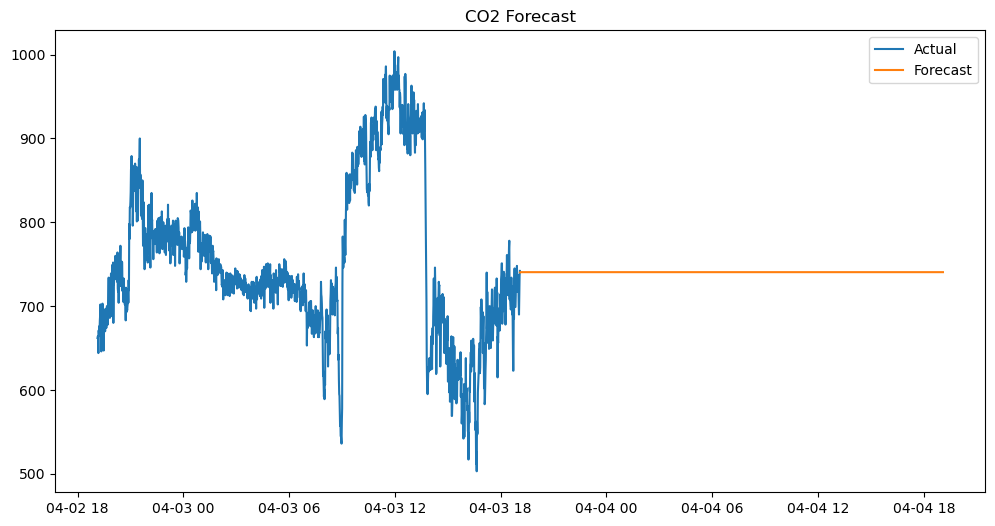

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Decompose the time series
decomposition = seasonal_decompose(co2['CO2'].dropna(), model='additive', period=24*60)  # Assuming hourly data

# Plot the decomposed time series
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
ax[0].plot(decomposition.observed)
ax[0].set_title('Original Time Series')
ax[1].plot(decomposition.trend)
ax[1].set_title('Trend Component')
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal Component')
ax[3].plot(decomposition.resid)
ax[3].set_title('Residual Component')
plt.tight_layout()
plt.show()

# Fit an ARIMA model
model = ARIMA(co2['CO2'].dropna(), order=(1, 1, 1))  # Example order, adjust based on ACF/PACF analysis
fitted_model = model.fit()

# Forecast future values
forecast = fitted_model.forecast(steps=24*60)  # Forecasting for the next 24 hours, assuming hourly data

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(co2['CO2'].index[-24*60:], co2['CO2'].values[-24*60:], label='Actual')
plt.plot(pd.date_range(co2.index[-1], periods=24*60, freq='T'), forecast, label='Forecast')  # Assuming hourly data
plt.title('CO2 Forecast')
plt.legend()
plt.show()


In [6]:
import numpy as np
from statsmodels.tsa.stattools import acf, q_stat
from scipy.stats import chi2


y = co2['CO2'].dropna()

# Fit a naive model
y_forecast = y.shift(1)

# Calculate residuals
residuals = y - y_forecast

# Calculate ACF of residuals
r = acf(residuals[1:], nlags=min(len(y) // 5, 10), fft=False)[1:]  # Exclude lag 0

# Calculate Ljung-Box Q statistic
Q, p_vals = q_stat(r, len(y))
Q = Q[-1]  # Take the last value of Q for the number of lags used
p_val = p_vals[-1]  # Corresponding p-value

# Print the results
print(f"Ljung-Box Q statistic: {Q}")
print(f"p-value: {p_val}")


Ljung-Box Q statistic: 6264.038811680234
p-value: 0.0
